# Denoiser - Learning in the dark (RAW)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [2]:
import cv2
print(cv2.__version__)

4.5.5


In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [ ]:
import os
for dirname, _, filenames in os.walk('Learning-to-See-in-the-Dark'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
# path to zipped & working directories
path_zip = 'Learning-to-See-in-the-Dark/dataset/'
path = 'Learning-to-See-in-the-Dark/dataset/Sony/'

In [7]:
# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?

# with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)

# with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)  
    
# with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)  
    
# with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)  

In [23]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train_short'))
train_cleaned_img = sorted(os.listdir(path + '/train_long'))
test_img = sorted(os.listdir(path + '/test_short'))

# Data preparation

In [24]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
#    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
#    img = img[:, :, 0]
    
    return img

In [25]:
# preprocess i#mages
train_short = []
train_long = []
test_short = []

for f in sorted(os.listdir(path + 'train_short/')):
    train_short.append(process_image(path + 'train_short/' + f))

for f in sorted(os.listdir(path + 'train_long/')):
    train_long.append(process_image(path + 'train_long/' + f))
   
for f in sorted(os.listdir(path + 'test_short/')):
    test_short.append(process_image(path + 'test_short/' + f))

# Exploratory data analysis

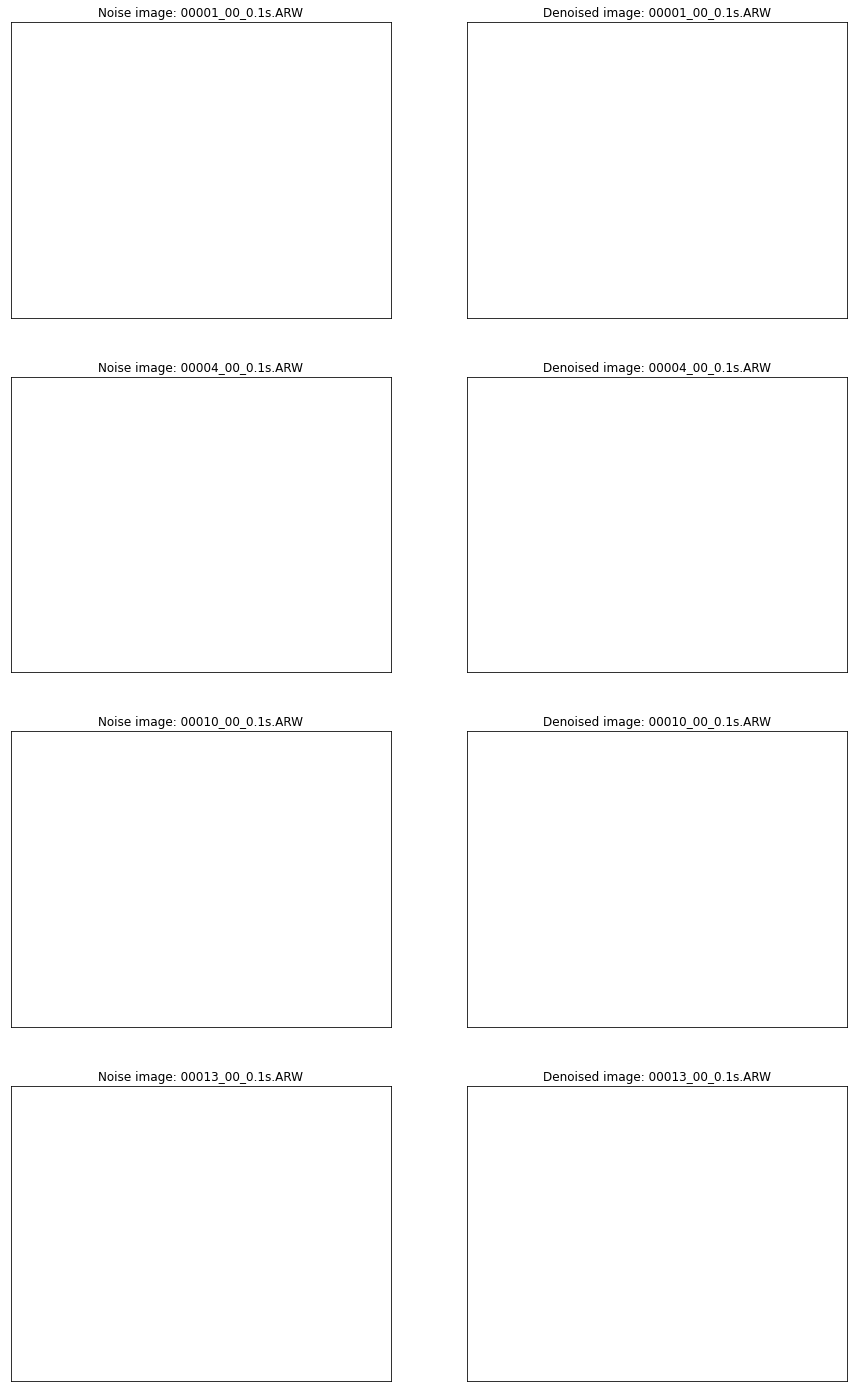

In [26]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_short[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_long[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

# Split data

In [11]:
# convert list to numpy array
X_train = np.asarray(train_short)
Y_train = np.asarray(train_long)
X_test = np.asarray(test_short)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

# Modeling

In [12]:
def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


In [13]:
model = model()

2022-04-07 13:16:24.727276: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-07 13:16:24.904860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 13:16:24.905062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 13:16:24.905229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

# Train model

In [15]:
callback = EarlyStopping(monitor='loss', patience=30)

In [16]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=0, callbacks=[callback])

2022-04-07 13:16:49.672457: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-07 13:16:50.205720: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


# Plot error evolution on epochs

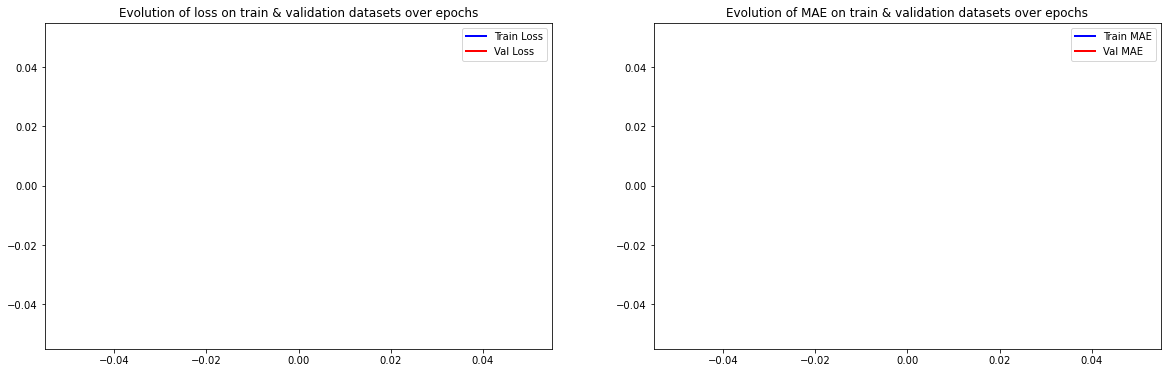

In [17]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

# Evaluation

In [18]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()